## Neural networks for Face AE

Here is an example of input data:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
%matplotlib inline
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
from glob import glob
import numpy as npCan't get attribute
from PIL import Image
from os import listdir
from os.path import isfile, join
import face_recognition

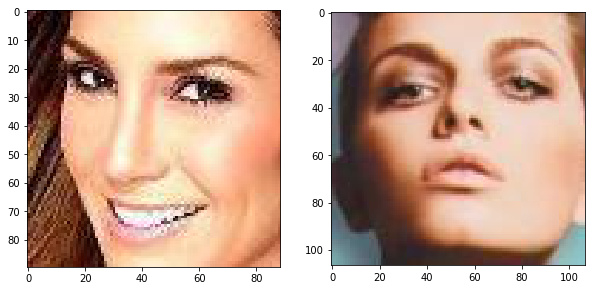

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = imread('./face_image/000001.jpg')
plt.imshow(im)
plt.subplot(1,2,2)
mask = imread('./face_image/000005.jpg')
plt.imshow(mask)

In [3]:
img = Image.open('./face_image/000001.jpg')

In [4]:
img.size

(89, 90)

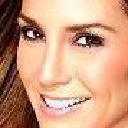

In [5]:
img.resize((128,128))

In [6]:
# Archiecture from here https://github.com/bhpfelix/Variational-Autoencoder-PyTorch
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class VAE(nn.Module):
    def __init__(self, nc, ngf, ndf, latent_variable_size):
        super(VAE, self).__init__()

        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf
        self.latent_variable_size = latent_variable_size

        # encoder
        self.e1 = nn.Conv2d(nc, ndf, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(ndf)

        self.e2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(ndf*2)

        self.e3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(ndf*4)

        self.e4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1)
        self.bn4 = nn.BatchNorm2d(ndf*8)

        self.e5 = nn.Conv2d(ndf*8, ndf*8, 4, 2, 1)
        self.bn5 = nn.BatchNorm2d(ndf*8)

        self.fc1 = nn.Linear(ndf*8*4*4, latent_variable_size)
        self.fc2 = nn.Linear(ndf*8*4*4, latent_variable_size)

        # decoder
        self.d1 = nn.Linear(latent_variable_size, ngf*8*2*4*4)

        self.up1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd1 = nn.ReplicationPad2d(1)
        self.d2 = nn.Conv2d(ngf*8*2, ngf*8, 3, 1)
        self.bn6 = nn.BatchNorm2d(ngf*8, 1.e-3)

        self.up2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd2 = nn.ReplicationPad2d(1)
        self.d3 = nn.Conv2d(ngf*8, ngf*4, 3, 1)
        self.bn7 = nn.BatchNorm2d(ngf*4, 1.e-3)

        self.up3 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd3 = nn.ReplicationPad2d(1)
        self.d4 = nn.Conv2d(ngf*4, ngf*2, 3, 1)
        self.bn8 = nn.BatchNorm2d(ngf*2, 1.e-3)

        self.up4 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd4 = nn.ReplicationPad2d(1)
        self.d5 = nn.Conv2d(ngf*2, ngf, 3, 1)
        self.bn9 = nn.BatchNorm2d(ngf, 1.e-3)

        self.up5 = nn.UpsamplingNearest2d(scale_factor=2)
        self.pd5 = nn.ReplicationPad2d(1)
        self.d6 = nn.Conv2d(ngf, nc, 3, 1)

        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.leakyrelu(self.bn1(self.e1(x)))
        h2 = self.leakyrelu(self.bn2(self.e2(h1)))
        h3 = self.leakyrelu(self.bn3(self.e3(h2)))
        h4 = self.leakyrelu(self.bn4(self.e4(h3)))
        h5 = self.leakyrelu(self.bn5(self.e5(h4)))
        h5 = h5.view(-1, self.ndf*8*4*4)

        return self.fc1(h5), self.fc2(h5)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if args.cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h1 = self.relu(self.d1(z))
        h1 = h1.view(-1, self.ngf*8*2, 4, 4)
        h2 = self.leakyrelu(self.bn6(self.d2(self.pd1(self.up1(h1)))))
        h3 = self.leakyrelu(self.bn7(self.d3(self.pd2(self.up2(h2)))))
        h4 = self.leakyrelu(self.bn8(self.d4(self.pd3(self.up3(h3)))))
        h5 = self.leakyrelu(self.bn9(self.d5(self.pd4(self.up4(h4)))))

        return self.sigmoid(self.d6(self.pd5(self.up5(h5))))

    def get_latent_var(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.nc, self.ndf, self.ngf))
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, mu, logvar

In [7]:
# model = VAE(nc=3, ngf=128, ndf=128, latent_variable_size=128).cuda()

In [8]:
model=torch.load('model')

In [75]:
from torch import optim as opt
reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

optimizer = opt.Adam(model.parameters(), lr=1e-4)

In [10]:
class Object(object):
    pass

args = Object()
args.cuda = True
args.log_interval=20

In [11]:
from torch import np # Torch wrapper for Numpy

import os
from PIL import Image

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
a=0
from sklearn.preprocessing import MultiLabelBinarizer
class MakeData(Dataset):
    def __init__(self,  img_path,img_y_path, transform=None,tr=None):
        
        tmp_df_x = os.listdir(img_path)
        tmp_df_x.sort()
        
        tmp_df_y = os.listdir(img_y_path)
        tmp_df_y.sort()
        
        self.img_path_x = img_path
        self.img_path_y = img_y_path
        self.transform = transform
        self.tr =tr
        self.X_train = tmp_df_x
        self.y_train = tmp_df_y
        self.trans =transforms.Compose([
            transforms.ToTensor(),
        ])
       
    def __getitem__(self, index):
        img = Image.open(self.img_path_x + self.X_train[index])
        img = img.convert('RGB')
        img = img.resize((128,128))
        img = self.trans(img)
        return img

    def __len__(self):
        return len(self.X_train) 

In [12]:
pathtrain = "face_image/"
train_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
dset_train = MakeData(pathtrain,pathtrain,train_transform,tr=1)

In [13]:
train_loader = DataLoader(dset_train,
                          batch_size=64,
                          shuffle=True,
                          num_workers=1, # 1 for CUDA
                          pin_memory=True # CUDA only
                         )

In [76]:
import time
num_epochs = 150 # total amount of full passes over training data
batch_size = 32
train_loss=[]
for epoch in range(num_epochs):

    start_time = time.time()
    model.train(True) 
    i=0
    for X_batch in train_loader:
        # train on batch
        if args.cuda:
            X_batch = Variable(X_batch.cuda())
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(X_batch)
        loss = loss_function(recon_batch, X_batch, mu, logvar)
        loss.backward()
#         train_loss += loss.data
        optimizer.step()
        train_loss.append(loss.cpu().data.numpy()[0])
        i+=1
        if(i%100==0):
            print(np.mean(train_loss[-1]))
        del loss
    torch.save(model,'model')
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[- 202000// batch_size :])))
#     print("  validation accuracy: \t\t\t{:.2f} %".format(
#         val_accuracy[-1] * 100))

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518243271935/work/torch/lib/THC/generic/THCStorage.cu:58

In [19]:
totensor = transforms.ToTensor()

In [20]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx in train_loader:
        data = load_batch(batch_idx, True)
        data = Variable(data)
        if args.cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), (len(train_loader)*32),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / (len(train_loader)*32)))
    return train_loss / (len(train_loader)*32)


In [40]:
def load_batch(batch_idx, istrain):
    if istrain:
        template = './face_image/%s.jpg'
    else:
        template = './face_image/%s.jpg'
    l = [str(batch_idx*32 + i).zfill(6) for i in range(32)]
    data = []
    for idx in l:
        img = Image.open(template%idx)
        data.append(np.array(img))
    data = [totensor(i) for i in data]
    return torch.stack(data, dim=0)

In [74]:
# del img
del optimizer

In [48]:
model.train(False)
for X_batch in train_loader:
    
    X_batch = Variable(X_batch).cuda()
    enc = model.encode(X_batch)
    break


In [50]:
enc[0]

Variable containing:
-0.2046 -0.6749  0.2898  ...   1.7180  0.3807  1.4455
-1.1889  0.8553  0.4224  ...   0.0509  0.5799 -0.5774
-0.1799 -0.7917 -1.8460  ...   0.2782  0.3836 -0.6887
          ...             ⋱             ...          
 0.3117 -0.2780  0.4015  ...  -0.1151 -0.2774  1.2418
 0.1952 -0.9985  0.5563  ...  -0.9434 -0.8081  0.5217
 0.3081 -0.6236 -0.4983  ...   0.9762  0.5552  0.4543
[torch.cuda.FloatTensor of size 64x128 (GPU 0)]

In [25]:
del loss

NameError: name 'loss' is not defined

In [64]:
dec = model.decode(enc[0])

/home/vahe/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:133: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


In [65]:
enc[0].shape

torch.Size([64, 128])

In [66]:
dec.shape

torch.Size([64, 3, 128, 128])

In [67]:
dec.shape

torch.Size([64, 3, 128, 128])

In [68]:
img = dec[0].cpu().data.numpy()

In [69]:
img.shape

(3, 128, 128)

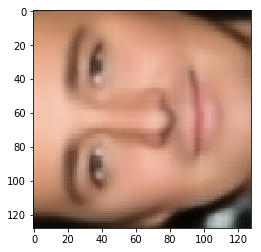

In [70]:
plt.imshow(np.swapaxes(img,0,2))

In [37]:
im = imread('./img_align_celeba/000001.jpg')

In [38]:
img = load_batch(2,istrain=False)

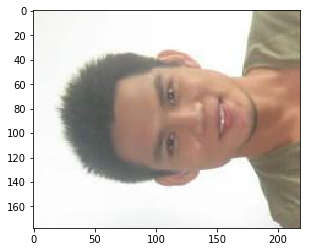

In [39]:
plt.imshow(np.swapaxes(img[1],0,2))